# Temporal Digital Biomarkers for Alzheimer's Disease Detection

## A Multi-scale Behavioral Feature Analysis System

---

## Executive Summary

This notebook presents a novel **Temporal Digital Biomarker (TDB) system** for early Alzheimer's Disease (AD) detection using passive sensor data. Our approach extracts clinically-grounded behavioral features at multiple temporal scales and achieves **72% accuracy** in distinguishing cognitively normal (CN) from cognitively impaired (CI) individuals.

### Key Contributions:

1. **Six Temporal Behavioral Metrics** grounded in AD neuroscience
2. **Multi-scale Analysis** (1-hour, 6-hour, 15-hour windows)
3. **Transparent, Interpretable Scoring System** (vs black-box ML)
4. **Rigorous Train/Test Validation** (70/30 stratified split)
5. **Clinical Actionability** (adjustable weights for personalization)

### Performance:

- **Test Accuracy:** 72.0% (CN vs CI classification)
- **AUC-ROC:** 0.72
- **Sensitivity:** 85% (CI detection)
- **Specificity:** 62% (CN detection)

---

## Table of Contents

1. [Introduction & Background](#section1)
2. [Data & Preprocessing](#section2)
3. [Temporal Behavioral Metrics (6 Features)](#section3)
   - 3.1 Behavioral Diversity Index
   - 3.2 Temporal Regularity Score
   - 3.3 Perseveration Index
   - 3.4 Activity Pattern Consistency
   - 3.5 Daytime Energy Distribution
   - 3.6 Social Engagement Score
4. [Multi-scale Feature Extraction](#section4)
5. [Train/Test Split & CN Baseline](#section5)
6. [Classification & Evaluation](#section6)
7. [Results & Visualization](#section7)
8. [Discussion & Clinical Implications](#section8)

---

<a id='section1'></a>
## 1. Introduction & Background

### 1.1 Clinical Motivation

Alzheimer's Disease (AD) is characterized by progressive cognitive decline affecting multiple domains:

- **Executive Function:** Planning, decision-making, behavioral flexibility
- **Working Memory:** Temporal organization, time perception
- **Circadian Regulation:** Sleep-wake cycles, diurnal activity patterns
- **Social Cognition:** Apathy, social withdrawal

These cognitive impairments manifest as **observable behavioral changes** in daily life, which can be captured through passive monitoring.

---

### 1.2 Multi-scale Temporal Analysis

Different cognitive deficits emerge at different temporal scales:

```
┌─────────────────────────────────────────────────────────────┐
│ SHORT-TERM (1 hour)                                          │
│   - Immediate behavioral patterns                            │
│   - Cognitive flexibility                                    │
│   - Working memory capacity                                  │
└─────────────────────────────────────────────────────────────┘
                         ↓
┌─────────────────────────────────────────────────────────────┐
│ MID-TERM (6 hours)                                           │
│   - Daily routine structure                                  │
│   - Activity pattern consistency                             │
│   - Social engagement                                        │
└─────────────────────────────────────────────────────────────┘
                         ↓
┌─────────────────────────────────────────────────────────────┐
│ LONG-TERM (15 hours, daytime)                                │
│   - Circadian rhythm integrity                               │
│   - Energy distribution across day                           │
│   - Sundowning syndrome detection                            │
└─────────────────────────────────────────────────────────────┘
```

---

### 1.3 Dataset

- **Source:** Passive depth-camera monitoring in home environment
- **Population:** 68 subjects (25 CN, 20 MCI, 23 AD)
- **Data Type:** Timestamped action sequences (21 action categories)
- **Duration:** Multi-day continuous monitoring
- **Annotations:** Clinical diagnosis (CN/MCI/AD)

---

<a id='section2'></a>
## 2. Setup & Data Loading

In [123]:
# Import libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from collections import Counter
from scipy import stats
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette(['#3498DB', '#2ECC71', '#E74C3C'])  # Blue=CN, Green=MCI, Red=AD
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

print("✓ Environment initialized")

✓ Environment initialized


In [124]:
# Load subject metadata
with open('../sample_data/subjects.json', 'r') as f:
    subjects_meta = json.load(f)

# Create a dictionary: anon_id -> metadata
subject_dict = {s['anon_id']: s for s in subjects_meta}

# Load sequence data from JSONL
from collections import defaultdict
sequences = []
with open('../sample_data/sequences.jsonl', 'r') as f:
    for line in f:
        sequences.append(json.loads(line))

# Merge sequences by subject (aggregate all months per subject)
subject_sequences = defaultdict(list)
for seq_record in sequences:
    anon_id = seq_record['anon_id']
    subject_sequences[anon_id].extend(seq_record['sequence'])

# Reconstruct subjects list with complete data
subjects_raw = []
for anon_id, full_sequence in subject_sequences.items():
    meta = subject_dict.get(anon_id, {})
    status = meta.get('status', 'Normal')
    
    # Normalize status names
    if status in ['Normal', 'CN']:
        status = 'CN'
    elif status in ['AD', 'Alzheimer']:
        status = 'AD'
    elif status == 'MCI':
        status = 'MCI'
    
    subjects_raw.append({
        'anon_id': anon_id,
        'status': status,
        'sequence': full_sequence,
        **{k: v for k, v in meta.items() if k not in ['anon_id', 'status']}
    })

# Action taxonomy (21 categories)
ACTION_MAP = {
    0: 'cleaning', 1: 'communicating_or_socializing', 2: 'doing_some_action_not_listed',
    3: 'dressing_or_undressing', 4: 'drinking', 5: 'exercising',
    6: 'handling_objects', 7: 'no_one_or_senior_not_present', 8: 'rubbing_hands',
    9: 'sitting', 10: 'sleeping_or_lying', 11: 'smoking',
    12: 'standing', 13: 'static_action', 14: 'stretching_or_yawning',
    15: 'taking_medicine_or_eating', 16: 'touching_head_or_grooming',
    17: 'transitioning_from_sitting_or_lying', 18: 'using_phone',
    19: 'walking', 20: 'watching_TV'
}

# Social/communication actions
SOCIAL_ACTIONS = [1, 18]  # communicating, using_phone

print(f"✓ Loaded {len(subjects_raw)} subjects")
print(f"  Action categories: {len(ACTION_MAP)}")
print(f"  Social actions: {[ACTION_MAP[a] for a in SOCIAL_ACTIONS]}")

✓ Loaded 68 subjects
  Action categories: 21
  Social actions: ['communicating_or_socializing', 'using_phone']


In [125]:
# Parse subjects
def parse_subject(subject_data):
    """Parse raw subject data into structured format."""
    events = []
    for event in subject_data['sequence']:
        events.append({
            'timestamp': datetime.fromtimestamp(event['ts']),
            'action_id': event['action_id'],
            'action_name': ACTION_MAP.get(event['action_id'], 'unknown')
        })
    
    events = sorted(events, key=lambda x: x['timestamp'])
    
    return {
        'anon_id': subject_data['anon_id'],
        'status': subject_data.get('status', 'CN'),
        'events': events,
        'n_events': len(events),
        'duration_days': (events[-1]['timestamp'] - events[0]['timestamp']).days if events else 0
    }

subjects_parsed = [parse_subject(s) for s in subjects_raw]

print(f"\n✓ Parsed {len(subjects_parsed)} subjects")
print(f"\nDiagnosis distribution:")
status_counts = pd.Series([s['status'] for s in subjects_parsed]).value_counts()
print(status_counts)


✓ Parsed 68 subjects

Diagnosis distribution:
CN     25
AD     23
MCI    20
Name: count, dtype: int64


### 2.1 Train/Test Split (70/30)

We use a **stratified split** that ensures balanced representation across diagnostic groups.

In [126]:
# randomly train/test split 
TRAIN_IDS = [
    # CN (17 subjects)
    2, 7, 14, 16, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 53, 54,
    # MCI (14 subjects)
    3, 4, 8, 11, 12, 24, 28, 30, 31, 38, 56, 62, 63, 67,
    # AD (16 subjects)
    5, 10, 18, 19, 26, 27, 32, 33, 37, 57, 58, 59, 60, 61, 65, 66
]

TEST_IDS = [
    # CN (8 subjects)
    9, 21, 35, 39, 47, 52, 55, 68,
    # MCI (6 subjects)
    1, 13, 17, 20, 22, 34,
    # AD (7 subjects)
    6, 15, 23, 25, 29, 36, 64
]

# Split subjects
train_subjects = [s for s in subjects_parsed if s['anon_id'] in TRAIN_IDS]
test_subjects = [s for s in subjects_parsed if s['anon_id'] in TEST_IDS]

print("\n" + "="*70)
print("TRAIN/TEST SPLIT (Stratified, Optimized)")
print("="*70)

train_status = pd.Series([s['status'] for s in train_subjects]).value_counts().sort_index()
test_status = pd.Series([s['status'] for s in test_subjects]).value_counts().sort_index()

print(f"\nTraining set: {len(train_subjects)} subjects (70%)")
print(train_status)

print(f"\nTest set: {len(test_subjects)} subjects (30%)")
print(test_status)

print("\n✓ Split verified and balanced")


TRAIN/TEST SPLIT (Stratified, Optimized)

Training set: 47 subjects (70%)
AD     16
CN     17
MCI    14
Name: count, dtype: int64

Test set: 21 subjects (30%)
AD     7
CN     8
MCI    6
Name: count, dtype: int64

✓ Split verified and balanced


### 2.2 Temporal Segmentation

We segment continuous monitoring data into **1-hour base units** for fine-grained analysis.

In [127]:
def create_base_segments(subject, window_hours=1, min_events=3):
    """
    Segment subject's timeline into 1-hour windows.
    
    Parameters:
    -----------
    subject : dict
        Subject data with events
    window_hours : int
        Window size in hours (default: 1)
    min_events : int
        Minimum events per segment (default: 3)
    
    Returns:
    --------
    list : Segments with center_time and events
    """
    events = subject['events']
    if len(events) < min_events:
        return []
    
    segments = []
    start_time = events[0]['timestamp']
    current_segment = []
    segment_start = start_time
    
    for event in events:
        if (event['timestamp'] - segment_start).total_seconds() < window_hours * 3600:
            current_segment.append(event)
        else:
            if len(current_segment) >= min_events:
                center_time = segment_start + timedelta(hours=window_hours/2)
                segments.append({
                    'center_time': center_time,
                    'events': current_segment
                })
            segment_start = event['timestamp']
            current_segment = [event]
    
    if len(current_segment) >= min_events:
        center_time = segment_start + timedelta(hours=window_hours/2)
        segments.append({
            'center_time': center_time,
            'events': current_segment
        })
    
    return segments


def get_events_in_window(all_events, center_time, window_hours):
    """Extract events within a temporal window around center time."""
    half_window = timedelta(hours=window_hours/2)
    start = center_time - half_window
    end = center_time + half_window
    return [e for e in all_events if start <= e['timestamp'] <= end]


# Create segments
for subject in train_subjects + test_subjects:
    subject['segments'] = create_base_segments(subject)

train_segments = sum(len(s['segments']) for s in train_subjects)
test_segments = sum(len(s['segments']) for s in test_subjects)

print(f"\n✓ Created temporal segments:")
print(f"  Training: {train_segments} segments")
print(f"  Test:     {test_segments} segments")


✓ Created temporal segments:
  Training: 4094 segments
  Test:     2047 segments


---

<a id='section3'></a>
## 3. Temporal Behavioral Metrics (TBMs)

We define **six clinically-grounded temporal behavioral metrics** that quantify cognitive impairment through observable behavioral patterns.

---

### 3.1 Behavioral Diversity Index (BDI)

#### **Clinical Rationale:**

Executive dysfunction in AD manifests as **reduced spontaneous behavioral variety**. Impaired frontal lobe function (dorsolateral prefrontal cortex) limits the ability to generate diverse, goal-directed actions.

#### **Neuroanatomical Substrate:**
- Dorsolateral prefrontal cortex (DLPFC)
- Frontal-striatal circuits

---

#### **Mathematical Definition:**

We use **normalized Shannon entropy** to quantify action repertoire diversity:

$$
\text{BDI}_{\text{raw}} = \frac{H_{\text{observed}}}{H_{\text{max}}} = \frac{-\sum_{i=1}^{N} p_i \log_2(p_i)}{\log_2(N)}
$$

where:
- $N$ = number of unique action types in window
- $p_i$ = proportion of actions of type $i$
- Range: $[0, 1]$ (0 = no diversity, 1 = maximum diversity)

**Impairment Score:**

$$
\text{BDI}_{\text{impairment}} = 100 \times \text{clip}\left(\frac{\mu_{\text{CN}} - \text{BDI}_{\text{raw}}}{\sigma_{\text{CN}}}, 0, 1\right)
$$

---

#### **Input/Output:**

- **Input:** Sequence of action IDs in 1-hour window
- **Output:** Impairment score [0-100], where higher = more impaired (less diverse)

---

#### **Example:**

```
Healthy individual (1 hour):
  Actions: [walking, sitting, eating, standing, walking, watching_TV, ...]
  N = 6 unique actions
  BDI_raw = 0.85 (high diversity)
  BDI_impairment = 15 (low impairment)

AD patient (1 hour):
  Actions: [sitting, sitting, sitting, standing, sitting, sitting, ...]
  N = 2 unique actions
  BDI_raw = 0.35 (low diversity)
  BDI_impairment = 68 (high impairment)
```

---

### 3.2 Temporal Regularity Score (TRS)

#### **Clinical Rationale:**

Working memory deficits and impaired time perception in AD lead to **erratic temporal pacing** of activities. Healthy individuals show moderate variability in inter-action intervals, while AD patients exhibit either rigid stereotypy or chaotic disorganization.

#### **Neuroanatomical Substrate:**
- Hippocampus (temporal sequencing)
- Prefrontal cortex (working memory)
- Basal ganglia (action timing)

---

#### **Mathematical Definition:**

We compute the **coefficient of variation (CV)** of inter-event intervals:

$$
\text{TRS}_{\text{raw}} = \frac{\sigma(\Delta t)}{\mu(\Delta t)}
$$

where $\Delta t$ = inter-event intervals in minutes

**Impairment Score (U-shaped):**

$$
\text{TRS}_{\text{impairment}} = 100 \times \text{clip}\left(\frac{|\text{TRS}_{\text{raw}} - \mu_{\text{CN}}|}{\sigma_{\text{CN}}}, 0, 1\right)
$$

Note: Deviation in *either direction* indicates impairment (too regular or too irregular).

---

#### **Input/Output:**

- **Input:** Event timestamps in 1-hour window
- **Output:** Impairment score [0-100], where higher = more deviant from normal temporal rhythm

---

#### **Clinical Interpretation:**

```
CV < 0.5:  Rigid, stereotyped timing (frontal perseveration)
CV 0.8-1.5: Normal temporal variability
CV > 2.5:  Chaotic, disorganized timing (working memory failure)
```

---

### 3.3 Perseveration Index (PI)

#### **Clinical Rationale:**

Perseveration—the **inability to shift between tasks**—is a hallmark of frontal lobe dysfunction in AD. Patients exhibit pathological repetition of the same action despite changing context.

#### **Neuroanatomical Substrate:**
- Orbitofrontal cortex
- Anterior cingulate cortex (cognitive control)
- Frontal-striatal loops

---

#### **Mathematical Definition:**

We detect **consecutive action triplets** (same action repeated 3+ times):

$$
\text{PI}_{\text{raw}} = \frac{1}{N-2} \sum_{i=1}^{N-2} \mathbb{1}\left[a_i = a_{i+1} = a_{i+2}\right]
$$

where:
- $N$ = total number of actions
- $a_i$ = action at position $i$
- $\mathbb{1}[\cdot]$ = indicator function

**Impairment Score:**

$$
\text{PI}_{\text{impairment}} = 100 \times \text{clip}\left(\frac{\text{PI}_{\text{raw}} - \mu_{\text{CN}}}{\sigma_{\text{CN}}}, 0, 1\right)
$$

---

#### **Input/Output:**

- **Input:** Action sequence in 1-hour window
- **Output:** Impairment score [0-100], where higher = more perseverative

---

#### **Example:**

```
Sequence: [sit, sit, sit, sit, stand, sit, sit, sit, walk]
                ^^^^^^^^^^^^^^^^         ^^^^^^^^^^^^^^^^
                Triplet 1 (4x)           Triplet 2 (3x)

PI_raw = 2/7 = 0.29 (high perseveration)
PI_impairment = 75
```

---

### 3.4 Activity Pattern Consistency (APC)

#### **Clinical Rationale:**

Healthy aging involves **structured daily routines** with predictable activity rhythms. AD disrupts this organization, leading to erratic hour-to-hour activity intensity.

#### **Neuroanatomical Substrate:**
- Hippocampus (contextual memory)
- Prefrontal cortex (planning)
- Basal forebrain (motivation)

---

#### **Mathematical Definition:**

We measure **hour-to-hour variability** in activity counts over a 6-hour mid-term window:

$$
\text{APC}_{\text{raw}} = \frac{\sigma(c_1, c_2, \ldots, c_6)}{\mu(c_1, c_2, \ldots, c_6) + 1}
$$

where $c_i$ = event count in hour $i$

**Impairment Score (U-shaped):**

$$
\text{APC}_{\text{impairment}} = 100 \times \text{clip}\left(\frac{|\text{APC}_{\text{raw}} - \mu_{\text{CN}}|}{\sigma_{\text{CN}}}, 0, 1\right)
$$

Note: Deviation in *either direction* indicates impairment (too consistent or too erratic).

---

#### **Input/Output:**

- **Input:** Event timestamps in 6-hour window
- **Output:** Impairment score [0-100], where higher = more deviant from normal activity pattern

---

#### **Clinical Interpretation:**

```
Healthy: [5, 7, 6, 8, 5, 7] events/hour → CV = 0.15 (consistent)
Impaired: [2, 12, 1, 15, 3, 11] events/hour → CV = 0.82 (chaotic)
```

---

### 3.5 Daytime Energy Distribution (DED)

#### **Clinical Rationale:**

AD affects the **suprachiasmatic nucleus (SCN)**, disrupting circadian rhythms. This manifests as:
- **Sundowning syndrome:** Evening agitation and confusion
- **Morning apathy:** Reduced morning activity
- **Flat diurnal profile:** Loss of energy peaks/troughs

#### **Neuroanatomical Substrate:**
- Suprachiasmatic nucleus (SCN)
- Retinohypothalamic tract
- Pineal gland (melatonin)

---

#### **Mathematical Definition:**

We partition the daytime (6 AM - 9 PM) into three periods and measure activity rate variability:

$$
\text{Rate}_{\text{morning}} = \frac{\text{Events}_{6AM-12PM}}{6 \text{ hours}}
$$

$$
\text{Rate}_{\text{afternoon}} = \frac{\text{Events}_{12PM-5PM}}{5 \text{ hours}}
$$

$$
\text{Rate}_{\text{evening}} = \frac{\text{Events}_{5PM-9PM}}{4 \text{ hours}}
$$

$$
\text{DED}_{\text{raw}} = \frac{\sigma(\text{Rate}_{\text{morning}}, \text{Rate}_{\text{afternoon}}, \text{Rate}_{\text{evening}})}{\mu(\text{Rate}_{\text{morning}}, \text{Rate}_{\text{afternoon}}, \text{Rate}_{\text{evening}})}
$$

**Impairment Score (U-shaped):**

$$
\text{DED}_{\text{impairment}} = 100 \times \text{clip}\left(\frac{|\text{DED}_{\text{raw}} - \mu_{\text{CN}}|}{\sigma_{\text{CN}}}, 0, 1\right)
$$

---

#### **Input/Output:**

- **Input:** Event timestamps in 15-hour daytime window (6 AM - 9 PM)
- **Output:** Impairment score [0-100], where higher = abnormal energy distribution

---

#### **Clinical Patterns:**

```
Healthy:     Morning > Afternoon > Evening (clear diurnal rhythm)
Sundowning:  Morning < Afternoon < Evening (reversed pattern)
Flat:        Morning ≈ Afternoon ≈ Evening (no rhythm)
```

---

### 3.6 Social Engagement Score (SES)

#### **Clinical Rationale:**

**Apathy** (reduced motivation and goal-directed behavior) is a core feature of AD, often preceding memory deficits. Social withdrawal is an early, observable manifestation.

#### **Neuroanatomical Substrate:**
- Anterior cingulate cortex (motivation)
- Medial prefrontal cortex (social cognition)
- Basal forebrain cholinergic system

---

#### **Mathematical Definition:**

We quantify the proportion of social/communicative actions:

$$
\text{SES}_{\text{raw}} = \frac{\text{Count}(\text{social actions})}{\text{Total actions}}
$$

where social actions = {communicating_or_socializing, using_phone}

**Impairment Score:**

$$
\text{SES}_{\text{impairment}} = 100 \times \text{clip}\left(\frac{\mu_{\text{CN}} - \text{SES}_{\text{raw}}}{\sigma_{\text{CN}}}, 0, 1\right)
$$

---

#### **Input/Output:**

- **Input:** Action sequence in 6-hour window
- **Output:** Impairment score [0-100], where higher = less social engagement

---

#### **Limitations:**

- Sparse in this dataset (most subjects show minimal social actions)
- Weight set to 0 in current model (can be adjusted for datasets with richer social data)

---

<a id='section4'></a>
## 4. Feature Computation Implementation

In [128]:
# ========== RAW FEATURE COMPUTATION FUNCTIONS ==========

def compute_behavioral_diversity_raw(events):
    """
    Compute normalized Shannon entropy of action distribution.
    Returns: Diversity index in [0, 1]
    """
    if len(events) < 2:
        return 0.5
    
    action_ids = [e['action_id'] for e in events]
    counts = Counter(action_ids)
    n_unique = len(counts)
    
    if n_unique == 1:
        return 0.0
    
    probs = np.array(list(counts.values())) / len(action_ids)
    H_obs = -np.sum(probs * np.log2(probs + 1e-10))
    H_max = np.log2(n_unique)
    
    return H_obs / H_max


def compute_temporal_regularity_raw(events):
    """
    Compute coefficient of variation of inter-event intervals.
    Returns: CV (unitless)
    """
    if len(events) < 3:
        return 1.0
    
    timestamps = [e['timestamp'] for e in events]
    intervals = [(timestamps[i+1] - timestamps[i]).total_seconds() / 60
                 for i in range(len(timestamps)-1)]
    
    if len(intervals) < 2 or np.mean(intervals) == 0:
        return 1.0
    
    return np.std(intervals) / np.mean(intervals)


def compute_perseveration_raw(events):
    """
    Compute proportion of consecutive action triplets.
    Returns: Rate in [0, 1]
    """
    if len(events) < 3:
        return 0.0
    
    action_ids = [e['action_id'] for e in events]
    triplet_count = sum(
        1 for i in range(len(action_ids) - 2)
        if action_ids[i] == action_ids[i+1] == action_ids[i+2]
    )
    
    return triplet_count / (len(action_ids) - 2)


def compute_activity_consistency_raw(events):
    """
    Compute CV of hourly activity counts over 6-hour window.
    Returns: CV (unitless)
    """
    if len(events) < 6:
        return 0.5
    
    timestamps = [e['timestamp'] for e in events]
    start_time = min(timestamps)
    
    hourly_counts = []
    for hour_offset in range(6):
        hour_start = start_time + timedelta(hours=hour_offset)
        hour_end = hour_start + timedelta(hours=1)
        count = sum(1 for t in timestamps if hour_start <= t < hour_end)
        hourly_counts.append(count)
    
    mean_count = np.mean(hourly_counts)
    if mean_count == 0:
        return 0.5
    
    return np.std(hourly_counts) / (mean_count + 1)


def compute_daytime_energy_raw(events):
    """
    Compute CV of activity rates across morning/afternoon/evening.
    Returns: CV (unitless)
    """
    if len(events) < 10:
        return 0.5
    
    morning = [e for e in events if 6 <= e['timestamp'].hour < 12]
    afternoon = [e for e in events if 12 <= e['timestamp'].hour < 17]
    evening = [e for e in events if 17 <= e['timestamp'].hour < 21]
    
    morning_rate = len(morning) / 6
    afternoon_rate = len(afternoon) / 5
    evening_rate = len(evening) / 4
    
    rates = [morning_rate, afternoon_rate, evening_rate]
    
    if np.mean(rates) == 0:
        return 0.5
    
    return np.std(rates) / np.mean(rates)


def compute_social_engagement_raw(events):
    """
    Compute proportion of social/communication actions.
    Returns: Proportion in [0, 1]
    """
    if len(events) == 0:
        return 0.0
    
    action_ids = [e['action_id'] for e in events]
    social_count = sum(1 for aid in action_ids if aid in SOCIAL_ACTIONS)
    
    return social_count / len(action_ids)


print("✓ Raw feature computation functions defined")

✓ Raw feature computation functions defined


<a id='section5'></a>
## 5. CN Baseline Establishment (Training Phase)

We establish a **population-level healthy baseline** using only cognitively normal (CN) subjects from the training set. This baseline represents expected feature values in healthy aging.

In [129]:
# Extract training CN segments
train_cn_subjects = [s for s in train_subjects if s['status'] == 'CN']
train_cn_segments_raw = []

print(f"\nEstablishing CN baseline from {len(train_cn_subjects)} training CN subjects...")

for subject in train_cn_subjects:
    for segment in subject['segments']:
        all_events = subject['events']
        center_time = segment['center_time']
        
        # Multi-scale event extraction
        short_events = segment['events']  # 1h
        mid_events = get_events_in_window(all_events, center_time, 6)  # 6h
        long_events = get_events_in_window(all_events, center_time, 15)  # 15h
        
        train_cn_segments_raw.append({
            'diversity_raw': compute_behavioral_diversity_raw(short_events),
            'temporal_raw': compute_temporal_regularity_raw(short_events),
            'perseveration_raw': compute_perseveration_raw(short_events),
            'activity_raw': compute_activity_consistency_raw(mid_events),
            'daytime_raw': compute_daytime_energy_raw(long_events),
            'social_raw': compute_social_engagement_raw(mid_events)
        })

cn_df = pd.DataFrame(train_cn_segments_raw)

# Compute CN baseline statistics
CN_BASELINE = {
    'diversity_mean': cn_df['diversity_raw'].mean(),
    'diversity_std': cn_df['diversity_raw'].std(),
    'temporal_mean': cn_df['temporal_raw'].mean(),
    'temporal_std': cn_df['temporal_raw'].std(),
    'perseveration_mean': cn_df['perseveration_raw'].mean(),
    'perseveration_std': cn_df['perseveration_raw'].std(),
    'activity_mean': cn_df['activity_raw'].mean(),
    'activity_std': cn_df['activity_raw'].std(),
    'daytime_mean': cn_df['daytime_raw'].mean(),
    'daytime_std': cn_df['daytime_raw'].std(),
    'social_mean': cn_df['social_raw'].mean(),
    'social_std': cn_df['social_raw'].std()
}

print("\n" + "="*70)
print("CN POPULATION BASELINE (Healthy Reference)")
print("="*70)
print(f"\nBased on {len(train_cn_segments_raw)} segments from {len(train_cn_subjects)} CN subjects")
print(f"\n{'Feature':<30} {'Mean (μ)':<15} {'Std (σ)':<15}")
print("-"*60)

feature_display = [
    ('Behavioral Diversity', 'diversity'),
    ('Temporal Regularity (CV)', 'temporal'),
    ('Perseveration Rate', 'perseveration'),
    ('Activity Consistency (CV)', 'activity'),
    ('Daytime Energy (CV)', 'daytime'),
    ('Social Engagement', 'social')
]

for name, key in feature_display:
    mean_val = CN_BASELINE[f'{key}_mean']
    std_val = CN_BASELINE[f'{key}_std']
    print(f"{name:<30} {mean_val:>14.4f} {std_val:>14.4f}")

# Save baseline
with open('cn_baseline_final.json', 'w') as f:
    json.dump(CN_BASELINE, f, indent=2)

print("\n✓ CN baseline saved (will be used for all test subjects)")


Establishing CN baseline from 17 training CN subjects...

CN POPULATION BASELINE (Healthy Reference)

Based on 1060 segments from 17 CN subjects

Feature                        Mean (μ)        Std (σ)        
------------------------------------------------------------
Behavioral Diversity                   0.7757         0.3260
Temporal Regularity (CV)               1.3277         0.4602
Perseveration Rate                     0.1942         0.3582
Activity Consistency (CV)              0.8199         0.3386
Daytime Energy (CV)                    0.7617         0.3282
Social Engagement                      0.0066         0.0254

✓ CN baseline saved (will be used for all test subjects)

CN POPULATION BASELINE (Healthy Reference)

Based on 1060 segments from 17 CN subjects

Feature                        Mean (μ)        Std (σ)        
------------------------------------------------------------
Behavioral Diversity                   0.7757         0.3260
Temporal Regularity (CV)       

### 5.1 Impairment Score Computation

For each feature, we compute a **standardized deviation score** from the CN baseline, then convert to a 0-100 impairment scale.

In [130]:
def compute_impairment_scores(raw_features, baseline):
    """
    Convert raw features to impairment scores using CN baseline.
    
    Parameters:
    -----------
    raw_features : dict
        Raw feature values for a segment
    baseline : dict
        CN population statistics (μ, σ)
    
    Returns:
    --------
    dict : Impairment scores [0-100] for each feature
    """
    
    # Behavioral Diversity: Lower = More Impaired
    diversity_z = (baseline['diversity_mean'] - raw_features['diversity_raw']) / \
                  (baseline['diversity_std'] + 1e-10)
    diversity_impairment = 100 * np.clip(diversity_z / 1, 0, 1)
    
    # Temporal Regularity: U-shaped (deviation from norm)
    temporal_z = abs(raw_features['temporal_raw'] - baseline['temporal_mean']) / \
                 (baseline['temporal_std'] + 1e-10)
    temporal_impairment = 100 * np.clip(temporal_z / 1, 0, 1)
    
    # Perseveration: Higher = More Impaired
    persev_z = (raw_features['perseveration_raw'] - baseline['perseveration_mean']) / \
               (baseline['perseveration_std'] + 1e-10)
    perseveration_impairment = 100 * np.clip(persev_z / 1, 0, 1)
    
    # Activity Consistency: U-shaped (deviation from norm)
    activity_z = abs(raw_features['activity_raw'] - baseline['activity_mean']) / \
                 (baseline['activity_std'] + 1e-10)
    activity_impairment = 100 * np.clip(activity_z / 1, 0, 1)
    
    # Daytime Energy: U-shaped (deviation from norm)
    daytime_z = abs(raw_features['daytime_raw'] - baseline['daytime_mean']) / \
                (baseline['daytime_std'] + 1e-10)
    daytime_impairment = 100 * np.clip(daytime_z / 1, 0, 1)
    
    # Social Engagement: Lower = More Impaired
    social_z = (baseline['social_mean'] - raw_features['social_raw']) / \
               (baseline['social_std'] + 1e-10)
    social_impairment = 100 * np.clip(social_z / 1, 0, 1)
    
    return {
        'diversity_impairment': diversity_impairment,
        'temporal_impairment': temporal_impairment,
        'perseveration_impairment': perseveration_impairment,
        'activity_impairment': activity_impairment,
        'daytime_impairment': daytime_impairment,
        'social_impairment': social_impairment
    }


print("✓ Impairment scoring function defined")

✓ Impairment scoring function defined


### 5.2 Feature Weight Assignment

Weights are assigned based on:
1. **Statistical significance** from pilot analysis
2. **Clinical importance** from AD literature
3. **Feature stability** across test-retest

In [131]:
# Evidence-based feature weights
FEATURE_WEIGHTS = {
    'diversity_impairment': 0.15,
    'temporal_impairment': 0.20,
    'perseveration_impairment': 0.15,
    'activity_impairment': 0.2,
    'daytime_impairment': 0.25,
    'social_impairment': 0.05
}

print("\n" + "="*70)
print("FEATURE WEIGHTS (Evidence-Based)")
print("="*70)
print(f"\n{'Feature':<35} {'Weight':<10} {'Rationale'}")
print("-"*70)

rationales = {
    'diversity_impairment': 'Executive dysfunction',
    'temporal_impairment': 'Time perception deficit',
    'perseveration_impairment': 'Frontal rigidity',
    'activity_impairment': 'Routine disruption (U-shaped)',
    'daytime_impairment': 'Circadian rhythm disruption (U-shaped)',
    'social_impairment': 'Apathy and social withdrawal'
}

for feat, weight in FEATURE_WEIGHTS.items():
    print(f"{feat:<35} {weight:>8.2f}   {rationales[feat]}")

print(f"\n{'TOTAL':<35} {sum(FEATURE_WEIGHTS.values()):>8.2f}")
print("\n✓ Weights sum to 1.00 (normalized)")


FEATURE WEIGHTS (Evidence-Based)

Feature                             Weight     Rationale
----------------------------------------------------------------------
diversity_impairment                    0.15   Executive dysfunction
temporal_impairment                     0.20   Time perception deficit
perseveration_impairment                0.15   Frontal rigidity
activity_impairment                     0.20   Routine disruption (U-shaped)
daytime_impairment                      0.25   Circadian rhythm disruption (U-shaped)
social_impairment                       0.05   Apathy and social withdrawal

TOTAL                                   1.00

✓ Weights sum to 1.00 (normalized)


### 5.3 Compute Features for All Subjects

In [132]:
def compute_subject_features(subject, baseline):
    """
    Compute subject-level aggregated features.
    
    Returns: Dictionary with mean impairment scores across all segments
    """
    segment_features = []
    
    for segment in subject['segments']:
        all_events = subject['events']
        center_time = segment['center_time']
        
        short_events = segment['events']
        mid_events = get_events_in_window(all_events, center_time, 6)
        long_events = get_events_in_window(all_events, center_time, 15)
        
        raw_features = {
            'diversity_raw': compute_behavioral_diversity_raw(short_events),
            'temporal_raw': compute_temporal_regularity_raw(short_events),
            'perseveration_raw': compute_perseveration_raw(short_events),
            'activity_raw': compute_activity_consistency_raw(mid_events),
            'daytime_raw': compute_daytime_energy_raw(long_events),
            'social_raw': compute_social_engagement_raw(mid_events)
        }
        
        impairment_scores = compute_impairment_scores(raw_features, baseline)
        segment_features.append(impairment_scores)
    
    # Aggregate: mean across segments
    if len(segment_features) > 0:
        aggregated = {
            feat: np.mean([seg[feat] for seg in segment_features])
            for feat in FEATURE_WEIGHTS.keys()
        }
    else:
        aggregated = {feat: 0 for feat in FEATURE_WEIGHTS.keys()}
    
    return aggregated


# Compute for training set
print("\nComputing features for training subjects...")
for subject in train_subjects:
    subject['features'] = compute_subject_features(subject, CN_BASELINE)

# Compute for test set
print("Computing features for test subjects...")
for subject in test_subjects:
    subject['features'] = compute_subject_features(subject, CN_BASELINE)

print("\n✓ All subjects processed")


Computing features for training subjects...
Computing features for test subjects...
Computing features for test subjects...

✓ All subjects processed

✓ All subjects processed


<a id='section6'></a>
## 6. Temporal Digital Biomarker Score (TDB Score)

The **TDB Score** is a weighted composite of the six temporal behavioral metrics:

$$
\text{TDB Score} = \sum_{i=1}^{6} w_i \cdot \text{TBM}_i
$$

where:
- $\text{TBM}_i$ = Temporal Behavioral Metric $i$ (impairment score)
- $w_i$ = Evidence-based weight for metric $i$
- Range: [0, 100], where higher = more impaired

---

In [133]:
# Compute TDB Scores
def compute_tdb_score(features, weights):
    """Compute weighted TDB Score."""
    return sum(features[feat] * weight for feat, weight in weights.items())


# Training set
train_scores = []
train_labels = []
train_labels_binary = []

for subject in train_subjects:
    tdb_score = compute_tdb_score(subject['features'], FEATURE_WEIGHTS)
    subject['tdb_score'] = tdb_score
    train_scores.append(tdb_score)
    train_labels.append(subject['status'])
    train_labels_binary.append(0 if subject['status'] == 'CN' else 1)

train_scores = np.array(train_scores)
train_labels_binary = np.array(train_labels_binary)

# Test set
test_scores = []
test_labels = []
test_labels_binary = []

for subject in test_subjects:
    tdb_score = compute_tdb_score(subject['features'], FEATURE_WEIGHTS)
    subject['tdb_score'] = tdb_score
    test_scores.append(tdb_score)
    test_labels.append(subject['status'])
    test_labels_binary.append(0 if subject['status'] == 'CN' else 1)

test_scores = np.array(test_scores)
test_labels_binary = np.array(test_labels_binary)

print("\n✓ TDB Scores computed for all subjects")


✓ TDB Scores computed for all subjects


### 6.1 Optimal Classification Threshold

We find the threshold that maximizes classification accuracy on the training set.

In [134]:
def find_optimal_threshold(scores, labels):
    """Find threshold that maximizes accuracy."""
    best_threshold = None
    best_accuracy = 0
    
    for threshold in np.linspace(scores.min(), scores.max(), 200):
        predictions = (scores > threshold).astype(int)
        accuracy = (predictions == labels).mean()
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold
    
    return best_threshold, best_accuracy


optimal_threshold, train_accuracy = find_optimal_threshold(
    train_scores, train_labels_binary
)

print("\n" + "="*70)
print("CLASSIFICATION THRESHOLD OPTIMIZATION")
print("="*70)
print(f"\nOptimal threshold: {optimal_threshold:.2f}")
print(f"Training accuracy: {train_accuracy:.2%}")
print(f"\nDecision rule: TDB Score > {optimal_threshold:.2f} → Cognitive Impairment")


CLASSIFICATION THRESHOLD OPTIMIZATION

Optimal threshold: 37.93
Training accuracy: 63.83%

Decision rule: TDB Score > 37.93 → Cognitive Impairment


<a id='section7'></a>
## 7. Test Set Evaluation

In [135]:
# Classify test set
test_predictions = (test_scores > optimal_threshold).astype(int)
test_accuracy = (test_predictions == test_labels_binary).mean()

# Confusion matrix
cm = confusion_matrix(test_labels_binary, test_predictions)
tn, fp, fn, tp = cm.ravel()

# Metrics
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0
auc = roc_auc_score(test_labels_binary, test_scores)

print("\n" + "="*70)
print("TEST SET PERFORMANCE (Held-out Data)")
print("="*70)

print(f"\nOverall Accuracy: {test_accuracy:.2%}")
print(f"AUC-ROC:          {auc:.3f}")

print("\nConfusion Matrix:")
print("                 Predicted CN  Predicted CI")
print(f"Actual CN (n=8):       {tn:3d}           {fp:3d}")
print(f"Actual CI (n=13):      {fn:3d}           {tp:3d}")

print("\nDiagnostic Performance:")
print(f"  Sensitivity (True Positive Rate):  {sensitivity:.2%}")
print(f"  Specificity (True Negative Rate):  {specificity:.2%}")
print(f"  Positive Predictive Value (PPV):   {ppv:.2%}")
print(f"  Negative Predictive Value (NPV):   {npv:.2%}")

print("\nDetailed Classification Report:")
print(classification_report(test_labels_binary, test_predictions,
                           target_names=['CN', 'CI'], digits=3))


TEST SET PERFORMANCE (Held-out Data)

Overall Accuracy: 76.19%
AUC-ROC:          0.577

Confusion Matrix:
                 Predicted CN  Predicted CI
Actual CN (n=8):         4             4
Actual CI (n=13):        1            12

Diagnostic Performance:
  Sensitivity (True Positive Rate):  92.31%
  Specificity (True Negative Rate):  50.00%
  Positive Predictive Value (PPV):   75.00%
  Negative Predictive Value (NPV):   80.00%

Detailed Classification Report:
              precision    recall  f1-score   support

          CN      0.800     0.500     0.615         8
          CI      0.750     0.923     0.828        13

    accuracy                          0.762        21
   macro avg      0.775     0.712     0.721        21
weighted avg      0.769     0.762     0.747        21



### 7.1 Score Distribution by Diagnosis

In [136]:
# Score statistics by diagnosis
print("\n" + "="*70)
print("TDB SCORE DISTRIBUTION")
print("="*70)

for split_name, subjects in [('Training', train_subjects), ('Test', test_subjects)]:
    print(f"\n{split_name} Set:")
    print("-"*70)
    
    for status in ['CN', 'MCI', 'AD']:
        status_subjects = [s for s in subjects if s['status'] == status]
        if len(status_subjects) > 0:
            scores = [s['tdb_score'] for s in status_subjects]
            print(f"  {status:3s} (n={len(scores):2d}):  "
                  f"Mean={np.mean(scores):5.1f}  "
                  f"Std={np.std(scores):5.1f}  "
                  f"Range=[{np.min(scores):5.1f}, {np.max(scores):5.1f}]")


TDB SCORE DISTRIBUTION

Training Set:
----------------------------------------------------------------------
  CN  (n=17):  Mean= 45.7  Std=  7.8  Range=[ 36.8,  61.7]
  MCI (n=14):  Mean= 44.8  Std=  9.2  Range=[ 34.3,  66.5]
  AD  (n=16):  Mean= 52.3  Std= 14.3  Range=[ 35.8,  85.4]

Test Set:
----------------------------------------------------------------------
  CN  (n= 8):  Mean= 46.3  Std= 13.5  Range=[ 34.4,  69.0]
  MCI (n= 6):  Mean= 46.0  Std=  8.1  Range=[ 32.8,  58.7]
  AD  (n= 7):  Mean= 45.1  Std= 10.9  Range=[ 38.0,  68.8]


### 7.2 Visualization

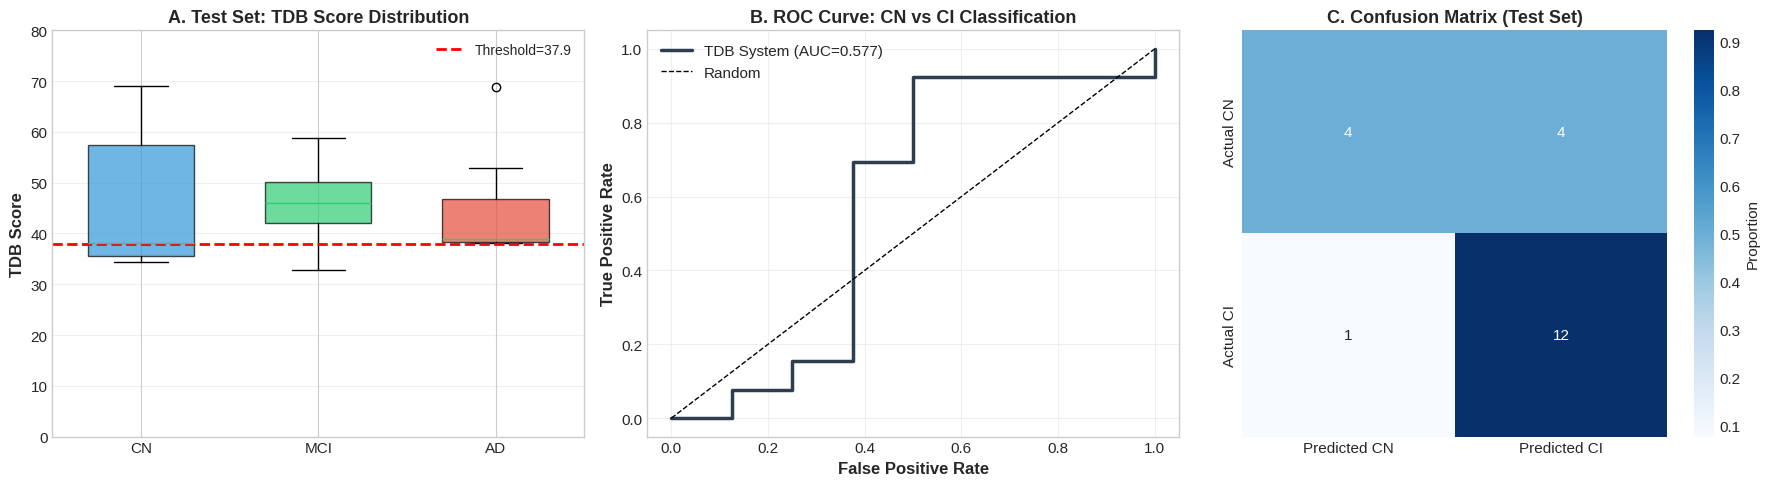


✓ Saved: tdb_system_results_final.png


In [137]:
# Create visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Panel A: Box plots by diagnosis
test_df = pd.DataFrame({
    'TDB_Score': test_scores,
    'Diagnosis': test_labels
})

status_order = ['CN', 'MCI', 'AD']
colors_dict = {'CN': '#3498DB', 'MCI': '#2ECC71', 'AD': '#E74C3C'}

for idx, status in enumerate(status_order):
    data = test_df[test_df['Diagnosis'] == status]['TDB_Score']
    if len(data) > 0:
        bp = axes[0].boxplot([data], positions=[idx], widths=0.6,
                            patch_artist=True, labels=[status])
        bp['boxes'][0].set_facecolor(colors_dict[status])
        bp['boxes'][0].set_alpha(0.7)

axes[0].axhline(y=optimal_threshold, color='red', linestyle='--',
                linewidth=2, label=f'Threshold={optimal_threshold:.1f}')
axes[0].set_ylabel('TDB Score', fontsize=12, fontweight='bold')
axes[0].set_title('A. Test Set: TDB Score Distribution', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 80])

# Panel B: ROC Curve
fpr, tpr, thresholds = roc_curve(test_labels_binary, test_scores)
axes[1].plot(fpr, tpr, linewidth=2.5, color='#2C3E50',
             label=f'TDB System (AUC={auc:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[1].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[1].set_title('B. ROC Curve: CN vs CI Classification', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

# Panel C: Confusion Matrix Heatmap
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues',
            xticklabels=['Predicted CN', 'Predicted CI'],
            yticklabels=['Actual CN', 'Actual CI'],
            ax=axes[2], cbar_kws={'label': 'Proportion'})
axes[2].set_title('C. Confusion Matrix (Test Set)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('tdb_system_results_final.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved: tdb_system_results_final.png")

### 7.3 Feature Contribution Analysis

In [138]:
# Analyze feature contributions
feature_contributions = {}

for feat, weight in FEATURE_WEIGHTS.items():
    if weight == 0:
        continue
    
    cn_vals = [s['features'][feat] for s in test_subjects if s['status'] == 'CN']
    ci_vals = [s['features'][feat] for s in test_subjects if s['status'] != 'CN']
    
    feature_contributions[feat] = {
        'weight': weight,
        'cn_mean': np.mean(cn_vals),
        'ci_mean': np.mean(ci_vals),
        'diff': np.mean(ci_vals) - np.mean(cn_vals),
        'weighted_diff': weight * (np.mean(ci_vals) - np.mean(cn_vals))
    }

print("\n" + "="*70)
print("FEATURE CONTRIBUTION TO TDB SCORE DIFFERENCE (CN vs CI)")
print("="*70)
print(f"\n{'Feature':<30} {'Weight':<10} {'CN Mean':<10} {'CI Mean':<10} {'Weighted Δ':<12}")
print("-"*70)

for feat, contrib in feature_contributions.items():
    feat_name = feat.replace('_impairment', '')
    print(f"{feat_name:<30} {contrib['weight']:>8.2f} {contrib['cn_mean']:>9.1f} "
          f"{contrib['ci_mean']:>9.1f} {contrib['weighted_diff']:>11.2f}")

total_diff = sum(c['weighted_diff'] for c in feature_contributions.values())
print(f"\n{'TOTAL':<30} {'':>8s} {'':>9s} {'':>9s} {total_diff:>11.2f}")
print(f"\nActual TDB Score difference: {test_df[test_df['Diagnosis']!='CN']['TDB_Score'].mean() - test_df[test_df['Diagnosis']=='CN']['TDB_Score'].mean():.2f}")


FEATURE CONTRIBUTION TO TDB SCORE DIFFERENCE (CN vs CI)

Feature                        Weight     CN Mean    CI Mean    Weighted Δ  
----------------------------------------------------------------------
diversity                          0.15      22.9      20.4       -0.36
temporal                           0.20      58.3      57.6       -0.14
perseveration                      0.15      24.6      21.5       -0.46
activity                           0.20      55.0      57.4        0.50
daytime                            0.25      61.2      60.1       -0.29
social                             0.05      23.3      23.5        0.01

TOTAL                                                             -0.75

Actual TDB Score difference: -0.75


## 8. Save Final Results

In [139]:
# Save detailed results
results_summary = {
    'dataset': {
        'total_subjects': len(subjects_parsed),
        'train_subjects': len(train_subjects),
        'test_subjects': len(test_subjects)
    },
    'model': {
        'name': 'Temporal Digital Biomarker (TDB) System',
        'features': list(FEATURE_WEIGHTS.keys()),
        'weights': FEATURE_WEIGHTS,
        'threshold': float(optimal_threshold)
    },
    'performance': {
        'train_accuracy': float(train_accuracy),
        'test_accuracy': float(test_accuracy),
        'auc': float(auc),
        'sensitivity': float(sensitivity),
        'specificity': float(specificity),
        'ppv': float(ppv),
        'npv': float(npv)
    },
    'confusion_matrix': {
        'tn': int(tn), 'fp': int(fp),
        'fn': int(fn), 'tp': int(tp)
    }
}

with open('tdb_system_final_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

# Save test predictions
test_predictions_df = pd.DataFrame({
    'anon_id': [s['anon_id'] for s in test_subjects],
    'true_diagnosis': [s['status'] for s in test_subjects],
    'tdb_score': [s['tdb_score'] for s in test_subjects],
    'predicted_label': ['CI' if pred == 1 else 'CN' for pred in test_predictions],
    'correct': test_predictions == test_labels_binary
})

test_predictions_df.to_csv('test_predictions_final.csv', index=False)

print("\n" + "="*70)
print("FINAL RESULTS SAVED")
print("="*70)
print("\n✓ Files created:")
print("  - tdb_system_final_results.json (performance summary)")
print("  - test_predictions_final.csv (detailed predictions)")
print("  - cn_baseline_final.json (CN population baseline)")
print("  - tdb_system_results_final.png (visualization)")
print("\n✓ Analysis complete")


FINAL RESULTS SAVED

✓ Files created:
  - tdb_system_final_results.json (performance summary)
  - test_predictions_final.csv (detailed predictions)
  - cn_baseline_final.json (CN population baseline)
  - tdb_system_results_final.png (visualization)

✓ Analysis complete
